In [1]:
import tensorflow as tf
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
import re
import pickle
from PIL import Image
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
train_dataset = pd.read_csv('Train_Data.csv')
test_dataset = pd.read_csv('Test_Data.csv')
cv_dataset = pd.read_csv('CV_Data.csv')

In [4]:
train_dataset.shape

(2758, 4)

In [5]:
chex = densenet.DenseNet121(include_top=False, weights = None, input_shape=(224,224,3))
#chex = densenet.DenseNet121(include_top=False, weights = None, input_shape=(224,224,3), pooling="avg") --> give u a 1024 length
                                                                                                            #feature vector

In [6]:
X = chex.output
X = Dense(14, activation="sigmoid", name="predictions")(X)
model = Model(inputs=chex.input, outputs=X)

In [7]:
# This contains weights for the CheXNet network
# It has the weight  for the last layer of the chexnet network as well, therefore an additional layer is added in the
# previous cell block to fit the weights which can be removed later.
model.load_weights('brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

In [8]:
model = Model(inputs = model.input, outputs = model.layers[-2].output)
# model.summary will show you all the layers in the model

In [9]:
def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X, (224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    
    return X

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


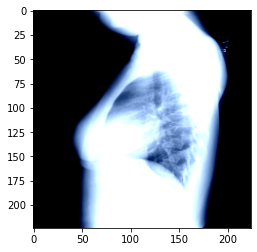

In [10]:
img = load_image('Scanned Images/CXR1_1_IM-0001-3001.png')
plt.imshow(img[0])

In [11]:
def image_features(train, test, cv):
    Xnet_features_attention = {}
    
    for key, img1, img2, finding in tqdm(train.values):
        i1 = load_image(img1)
        img1_features = model.predict(i1)

        i2 = load_image(img2)
        img2_features = model.predict(i2)

        input_ = np.concatenate((img1_features, img2_features), axis=2)
        input_ = tf.reshape(input_, (input_.shape[0], -1, input_.shape[-1]))

        Xnet_features_attention[key] = input_
    
    for key, img1, img2, finding in tqdm(test.values):
        i1 = load_image(img1)
        img1_features = model.predict(i1)

        i2 = load_image(img2)
        img2_features = model.predict(i2)

        input_ = np.concatenate((img1_features, img2_features), axis=2)
        input_ = tf.reshape(input_, (input_.shape[0], -1, input_.shape[-1]))

        Xnet_features_attention[key] = input_

    for key, img1, img2, finding in tqdm(cv.values):
        i1 = load_image(img1)
        img1_features = model.predict(i1)

        i2 = load_image(img2)
        img2_features = model.predict(i2)

        input_ = np.concatenate((img1_features, img2_features), axis=2)
        input_ = tf.reshape(input_, (input_.shape[0], -1, input_.shape[-1]))

        Xnet_features_attention[key] = input_
        
    return Xnet_features_attention

In [12]:
Xnet_features_attention = image_features(train_dataset, test_dataset, cv_dataset)

100%|████████████████████████████████████████████████████████████████████████████████| 550/550 [01:35<00:00,  5.73it/s]


In [13]:
Xnet_features_attention['Scanned Images/CXR1_1_IM-0001_0'].shape

TensorShape([1, 98, 1024])

In [14]:
# save the file for future use
f = open('Image_features_attention.pickle','wb')
pickle.dump(Xnet_features_attention, f)
f.close()

The Xnet features are stored in a dictionary and saved for future use.